# Random Forest Regression Test for VAE Encodings

This notebook evaluates the quality of the VAE's latent space by using a Random Forest regressor to predict AFM targets.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from models.factory import get_model
from src.dataset import TGADataset
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration
data_path = '../data/tga_afm/data.npz'
model_name = 'even_smaller_variational_autoencoder'
checkpoint_path = '/home/luiz/Documentos/ufmg/nanocomp/tga-feature-extraction/checkpoints/even_smaller_variational_autoencoder/cool_model_8_features_200/final.pth'
latent_dim = 8

# Random Forest parameters
n_estimators = 100
max_depth = 10
random_state = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 1. Load Model and Generate Encodings

In [3]:
# Load Dataset
dataset = TGADataset(data_path=data_path, mode='feature')
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

print(f"Dataset size: {len(dataset)} samples")

Dataset size: 33 samples


In [4]:
# Load Model
print(f"Loading model: {model_name}")
model = get_model(model_name, compressed_dim=latent_dim)
model.load_checkpoint(checkpoint_path, device)
model.to(device)
model.double()
model.eval()

print("Model loaded successfully")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading model: even_smaller_variational_autoencoder
Model loaded successfully
Model parameters: 38,294


In [5]:
# Generate encodings
encodings = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        encoding = model.encode(x_batch).cpu().numpy()
        encodings.append(encoding)
        all_labels.append(y_batch.numpy())

encodings = np.vstack(encodings)
Y = np.vstack(all_labels)

print(f"Encodings shape: {encodings.shape}")
print(f"Labels shape: {Y.shape}")

Encodings shape: (33, 8)
Labels shape: (33, 5, 5)


In [6]:
# Standardize encodings
scaler = StandardScaler()
encodings_scaled = scaler.fit_transform(encodings)

print(f"Scaled encodings - Mean: {encodings_scaled.mean():.4f}, Std: {encodings_scaled.std():.4f}")

Scaled encodings - Mean: -0.0000, Std: 1.0000


## 2. Define Target Variables

We'll test prediction for all 10 AFM target variables:
- Min Ferret (Mean & Median)
- Max Ferret (Mean & Median)
- Height (Mean & Median)
- Area (Mean & Median)
- Volume (Mean & Median)

In [7]:
# Define all target configurations
label_configs = [
    {'name': 'Min Ferret Mean',   'data': Y[:, 0, 0]},
    {'name': 'Max Ferret Mean',   'data': Y[:, 1, 0]},
    {'name': 'Height Mean',       'data': Y[:, 2, 0]},
    {'name': 'Area Mean',         'data': Y[:, 3, 0]},
    {'name': 'Volume Mean',       'data': Y[:, 4, 0]},
    {'name': 'Min Ferret Median', 'data': Y[:, 0, 1]},
    {'name': 'Max Ferret Median', 'data': Y[:, 1, 1]},
    {'name': 'Height Median',     'data': Y[:, 2, 1]},
    {'name': 'Area Median',       'data': Y[:, 3, 1]},
    {'name': 'Volume Median',     'data': Y[:, 4, 1]}
]

print(f"Testing {len(label_configs)} target variables")

Testing 10 target variables


## 3. Random Forest Regression with Leave-One-Out Cross-Validation

In [8]:
def evaluate_with_random_forest_loo(encodings, labels, n_estimators=500, max_depth=10, random_state=42):
    """
    Evaluate using Random Forest with Leave-One-Out Cross-Validation.
    
    Returns:
        r2_score: R² score
        mse: Mean Squared Error
        mae: Mean Absolute Error
        predictions: Array of LOO predictions
    """
    loo = LeaveOneOut()
    predictions = np.zeros_like(labels)
    
    for train_idx, test_idx in loo.split(encodings):
        X_train, X_test = encodings[train_idx], encodings[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]
        
        # Train Random Forest
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        # Predict
        pred = rf.predict(X_test)
        predictions[test_idx] = pred
    
    # Calculate metrics
    r2 = r2_score(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)
    
    return r2, mse, mae, predictions

In [9]:
# Run Random Forest evaluation for all targets
results = []

print("\n=== Random Forest Regression Results (LOO CV) ===")
print("=" * 80)

for config in label_configs:
    labels = config['data']
    
    print(f"\nEvaluating: {config['name']}")
    
    r2, mse, mae, predictions = evaluate_with_random_forest_loo(
        encodings_scaled, 
        labels,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    
    results.append({
        'Target': config['name'],
        'R² Score': r2,
        'MSE': mse,
        'MAE': mae,
        'Predictions': predictions
    })
    
    print(f"  R² = {r2:.4f}")
    print(f"  MSE = {mse:.4f}")
    print(f"  MAE = {mae:.4f}")

print("\n" + "=" * 80)


=== Random Forest Regression Results (LOO CV) ===

Evaluating: Min Ferret Mean
  R² = -0.0263
  MSE = 798.8025
  MAE = 17.7425

Evaluating: Max Ferret Mean
  R² = 0.2024
  MSE = 16061154.8390
  MAE = 3293.9645

Evaluating: Height Mean
  R² = -0.1772
  MSE = 2.0844
  MAE = 1.0360

Evaluating: Area Mean
  R² = -0.2090
  MSE = 391.9669
  MAE = 14.9228

Evaluating: Volume Mean
  R² = -0.2097
  MSE = 20.1599
  MAE = 3.6774

Evaluating: Min Ferret Median
  R² = -0.0597
  MSE = 2490.1686
  MAE = 30.9504

Evaluating: Max Ferret Median
  R² = 0.2636
  MSE = 117155907.0903
  MAE = 8789.4729

Evaluating: Height Median
  R² = -0.1986
  MSE = 1.8884
  MAE = 0.9965

Evaluating: Area Median
  R² = -0.3781
  MSE = 483.1168
  MAE = 16.8448

Evaluating: Volume Median
  R² = -0.1686
  MSE = 9.7305
  MAE = 2.2355



In [10]:
# Create results dataframe
results_df = pd.DataFrame([{
    'Target': r['Target'],
    'R² Score': r['R² Score'],
    'MSE': r['MSE'],
    'MAE': r['MAE']
} for r in results])

# Sort by R² score
results_df = results_df.sort_values('R² Score', ascending=False)

print("\n=== Summary Table ===")
print(results_df.to_string(index=False))

# Calculate average R²
avg_r2 = results_df['R² Score'].mean()
print(f"\n{'='*80}")
print(f"Average R² Score: {avg_r2:.4f}")
print(f"{'='*80}")


=== Summary Table ===
           Target  R² Score          MSE         MAE
Max Ferret Median  0.263566 1.171559e+08 8789.472879
  Max Ferret Mean  0.202379 1.606115e+07 3293.964477
  Min Ferret Mean -0.026288 7.988025e+02   17.742541
Min Ferret Median -0.059721 2.490169e+03   30.950431
    Volume Median -0.168603 9.730516e+00    2.235538
      Height Mean -0.177219 2.084433e+00    1.035954
    Height Median -0.198606 1.888390e+00    0.996515
        Area Mean -0.209005 3.919669e+02   14.922832
      Volume Mean -0.209685 2.015995e+01    3.677400
      Area Median -0.378144 4.831168e+02   16.844821

Average R² Score: -0.0961


## 4. Visualize Results

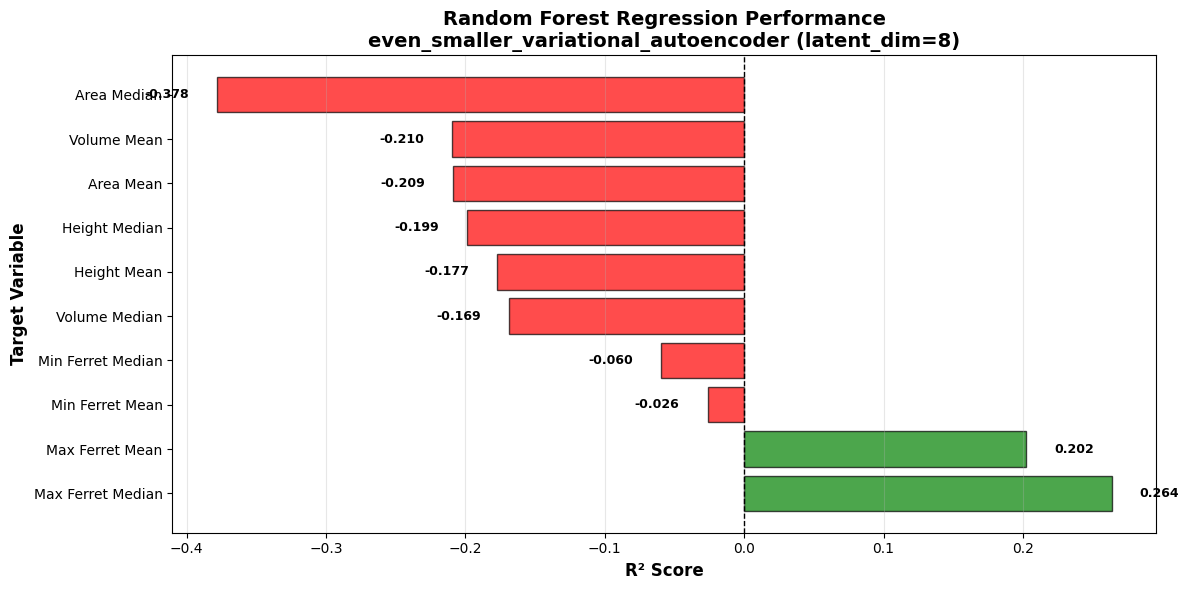

In [11]:
# Bar plot of R² scores
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if r2 > 0 else 'red' for r2 in results_df['R² Score']]
bars = ax.barh(results_df['Target'], results_df['R² Score'], color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('R² Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Target Variable', fontsize=12, fontweight='bold')
ax.set_title(f'Random Forest Regression Performance\n{model_name} (latent_dim={latent_dim})', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, r2) in enumerate(zip(bars, results_df['R² Score'])):
    width = bar.get_width()
    label_x_pos = width + 0.02 if width >= 0 else width - 0.02
    ha = 'left' if width >= 0 else 'right'
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{r2:.3f}',
            ha=ha, va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/rf_r2_scores.png', dpi=300, bbox_inches='tight')
plt.show()

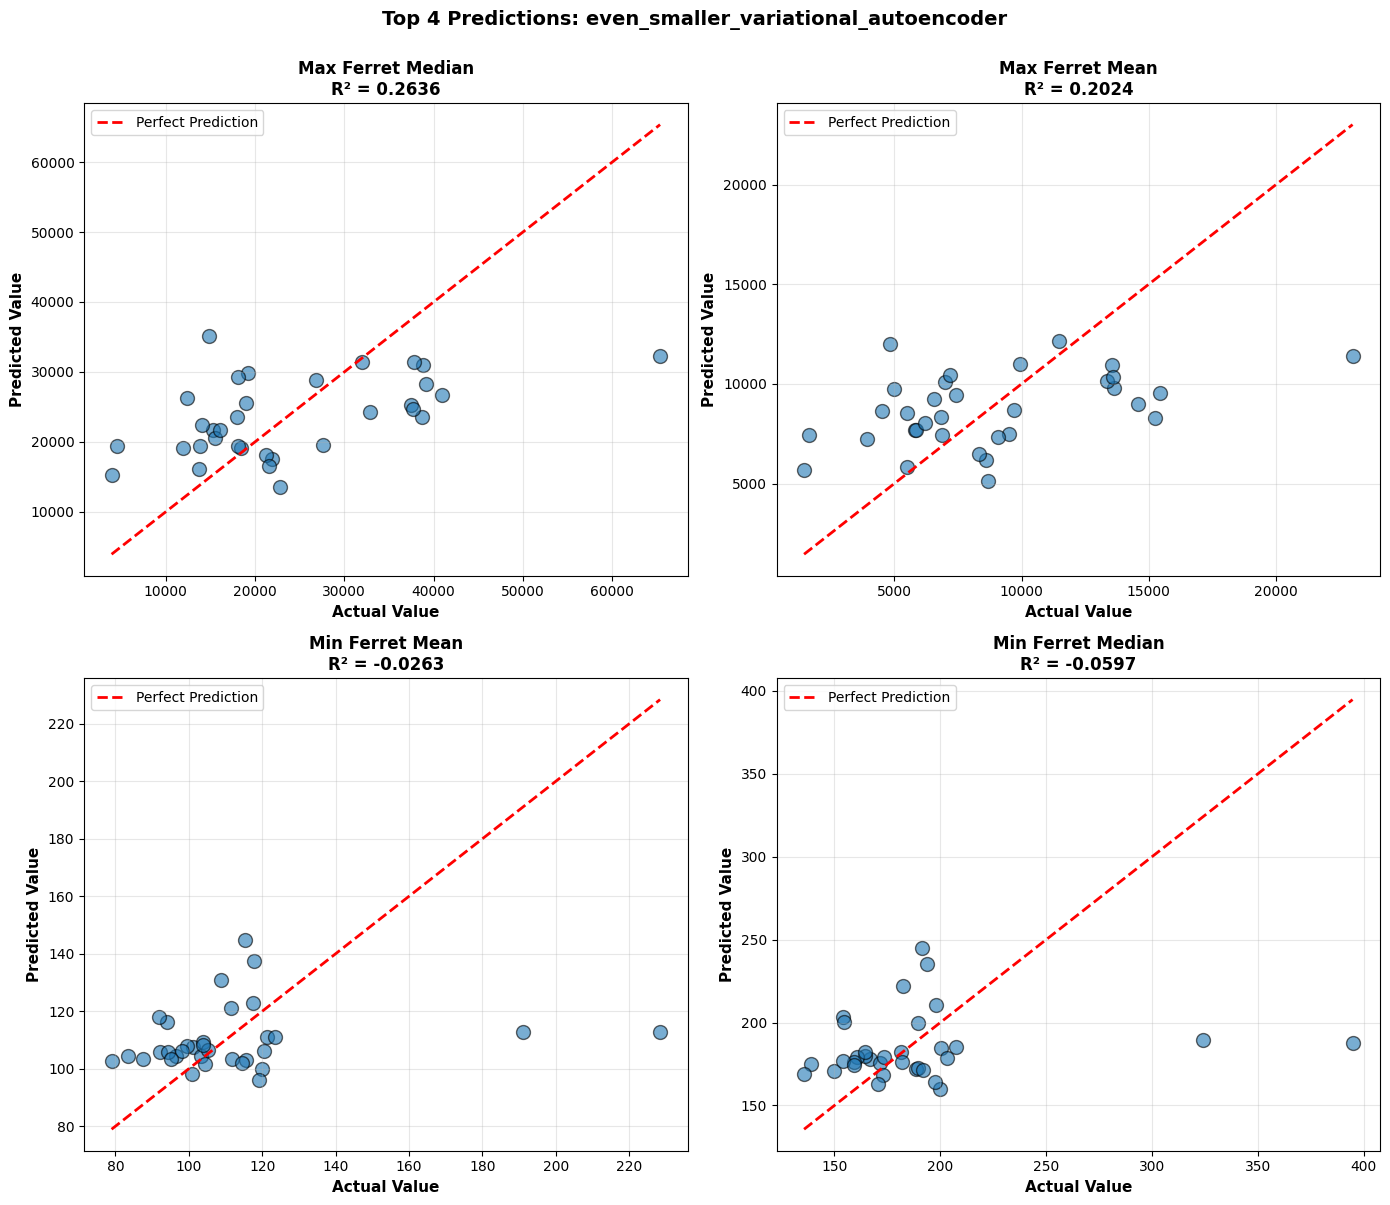

In [12]:
# Create prediction vs actual plots for top 4 targets
top_4_results = results_df.head(4)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (_, row) in enumerate(top_4_results.iterrows()):
    target_name = row['Target']
    r2 = row['R² Score']
    
    # Get predictions and actual values
    result = [r for r in results if r['Target'] == target_name][0]
    predictions = result['Predictions']
    actual = [config['data'] for config in label_configs if config['name'] == target_name][0]
    
    # Plot
    axes[idx].scatter(actual, predictions, alpha=0.6, s=100, edgecolors='black', linewidth=1)
    
    # Perfect prediction line
    min_val = min(actual.min(), predictions.min())
    max_val = max(actual.max(), predictions.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Value', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Predicted Value', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{target_name}\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='best')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle(f'Top 4 Predictions: {model_name}', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../figures/rf_top4_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. K-Fold Cross-Validation Comparison

In [13]:
def evaluate_with_random_forest_kfold(encodings, labels, n_splits=5, n_estimators=100, max_depth=10, random_state=42):
    """
    Evaluate using Random Forest with K-Fold Cross-Validation.
    """
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1
    )
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Cross-validate
    scores = cross_val_score(rf, encodings, labels, cv=kfold, scoring='r2')
    
    return scores.mean(), scores.std(), scores

# Compare LOO vs K-Fold for a few targets
print("\n=== Comparing LOO vs 5-Fold CV ===")
print("=" * 80)

comparison_targets = ['Min Ferret Mean', 'Height Mean', 'Area Mean', 'Volume Mean']

for target_name in comparison_targets:
    labels = [config['data'] for config in label_configs if config['name'] == target_name][0]
    
    # LOO result
    loo_r2 = [r['R² Score'] for r in results if r['Target'] == target_name][0]
    
    # K-Fold result
    kfold_mean, kfold_std, kfold_scores = evaluate_with_random_forest_kfold(
        encodings_scaled, labels, n_splits=5
    )
    
    print(f"\n{target_name}:")
    print(f"  LOO R²:    {loo_r2:.4f}")
    print(f"  5-Fold R²: {kfold_mean:.4f} ± {kfold_std:.4f}")
    print(f"  K-Fold scores: {[f'{s:.3f}' for s in kfold_scores]}")


=== Comparing LOO vs 5-Fold CV ===

Min Ferret Mean:
  LOO R²:    -0.0263
  5-Fold R²: -0.9792 ± 1.0111
  K-Fold scores: ['-0.121', '-2.786', '-0.415', '-0.187', '-1.387']

Height Mean:
  LOO R²:    -0.1772
  5-Fold R²: -0.5394 ± 0.8780
  K-Fold scores: ['-1.823', '0.212', '-1.352', '-0.069', '0.334']

Area Mean:
  LOO R²:    -0.2090
  5-Fold R²: -0.5950 ± 0.8923
  K-Fold scores: ['-0.970', '0.401', '-2.130', '-0.328', '0.053']

Volume Mean:
  LOO R²:    -0.2097
  5-Fold R²: -0.4628 ± 0.4893
  K-Fold scores: ['-1.131', '-0.676', '0.301', '-0.165', '-0.642']


## 6. Feature Importance Analysis


Analyzing feature importance for: Max Ferret Median


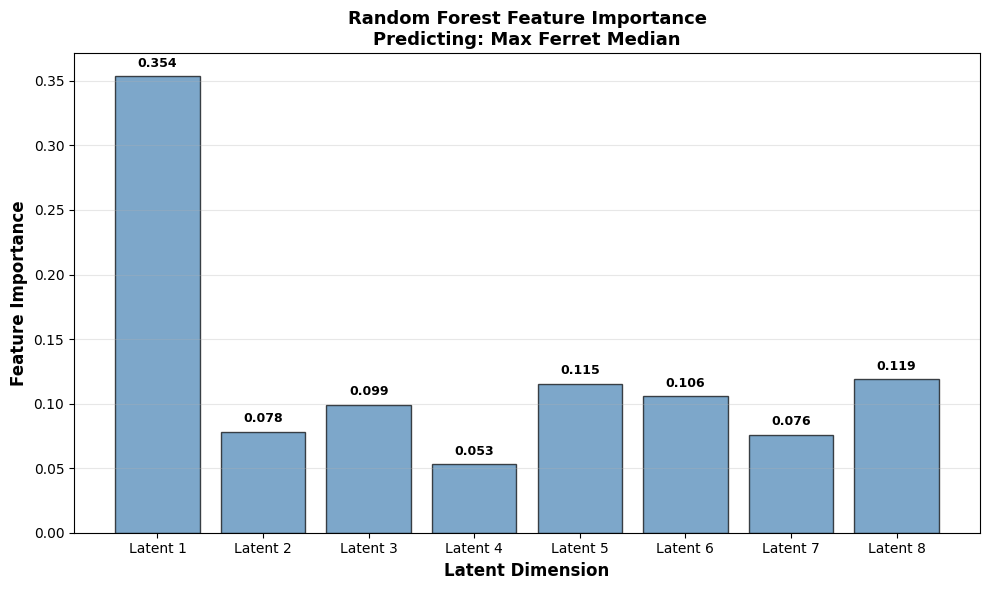


Feature Importances:
  Latent 1: 0.3538
  Latent 2: 0.0781
  Latent 3: 0.0991
  Latent 4: 0.0532
  Latent 5: 0.1153
  Latent 6: 0.1057
  Latent 7: 0.0759
  Latent 8: 0.1190


In [14]:
# Analyze feature importance for the best-performing target
best_target = results_df.iloc[0]['Target']
best_labels = [config['data'] for config in label_configs if config['name'] == best_target][0]

print(f"\nAnalyzing feature importance for: {best_target}")

# Train final Random Forest on all data
rf_final = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=random_state,
    n_jobs=-1
)
rf_final.fit(encodings_scaled, best_labels)

# Get feature importances
importances = rf_final.feature_importances_
feature_names = [f'Latent {i+1}' for i in range(latent_dim)]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(feature_names, importances, color='steelblue', alpha=0.7, edgecolor='black')

ax.set_xlabel('Latent Dimension', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Random Forest Feature Importance\nPredicting: {best_target}', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, imp in zip(bars, importances):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{imp:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFeature Importances:")
for name, imp in zip(feature_names, importances):
    print(f"  {name}: {imp:.4f}")

## 7. Save Results

In [15]:
# Save detailed results to CSV
output_path = '../results/rf_regression_results.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)

results_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# Print summary
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)
print(f"Model: {model_name}")
print(f"Latent Dimension: {latent_dim}")
print(f"Random Forest Config: n_estimators={n_estimators}, max_depth={max_depth}")
print(f"\nAverage R² Score: {avg_r2:.4f}")
print(f"Best Target: {results_df.iloc[0]['Target']} (R² = {results_df.iloc[0]['R² Score']:.4f})")
print(f"Worst Target: {results_df.iloc[-1]['Target']} (R² = {results_df.iloc[-1]['R² Score']:.4f})")
print("=" * 80)


Results saved to: ../results/rf_regression_results.csv

FINAL SUMMARY
Model: even_smaller_variational_autoencoder
Latent Dimension: 8
Random Forest Config: n_estimators=100, max_depth=10

Average R² Score: -0.0961
Best Target: Max Ferret Median (R² = 0.2636)
Worst Target: Area Median (R² = -0.3781)
